In [3]:
%matplotlib inline

In [20]:
import tensorflow as tf
import glob
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.pylab import *
# repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
# style.use("results/style_sheet.mplstyle")
# rc('figure', figsize=(8, 4))
plt.rcParams.update({'font.size': 16, 'lines.linewidth': 3})

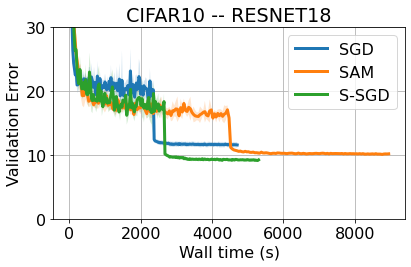

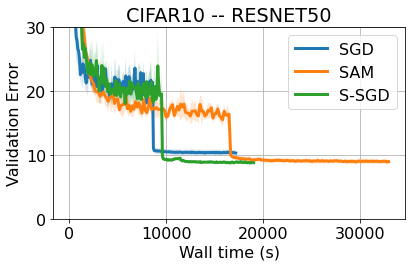

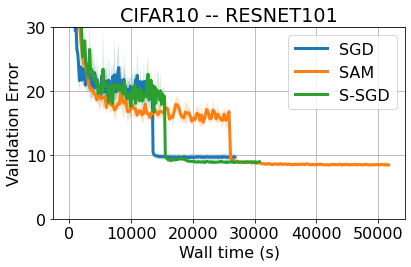

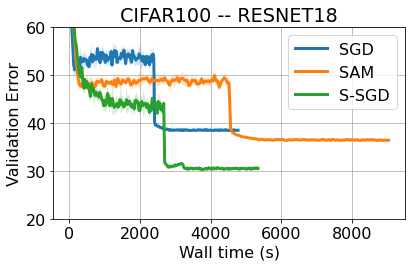

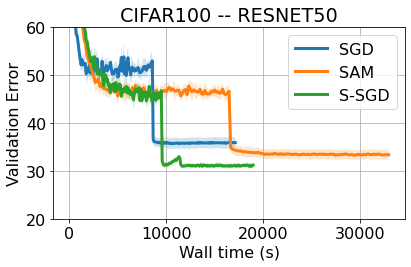

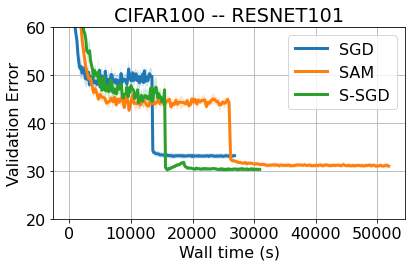

In [39]:
for dtype in ['cifar10','cifar100']:
    for mtype in ['resnet18','resnet50','resnet101']:
        alldata = {}
        def get_single_iteration_time(opt):
            file = glob.glob(f"../checkpoints/{dtype}_walltime/{mtype}/{opt}/run_ms_0/run0/*event*")[0]
            wall_time = []
            for e in tf.compat.v1.train.summary_iterator(file):
                for v in e.summary.value:
                    if v.tag == "Train/Train_Loss":
                        wall_time.append(e.wall_time)
            wall_time = [x - wall_time[0] for x in wall_time]
            itr_time = [wall_time[i+1] - wall_time[i] for i in range(len(wall_time)-1)]
            return np.mean(itr_time)


        for opt in ["sgd", "sam_sgd", "fsgd"]:
            folders = sorted(glob.glob(f'../checkpoints/{dtype}_new/{mtype}/{opt}/*'), key=lambda y: y.split('run_ms_')[1])
            alldata[f'{opt}'] = {
                'trainloss': np.zeros((200, len(folders))),
                'trainerr': np.zeros((200, len(folders))),
                'valloss': np.zeros((200, len(folders))),
                'valerr': np.zeros((200, len(folders))),
                'walltime': np.arange((199)) * get_single_iteration_time(f'{opt}')
            }
            data = alldata[f'{opt}']

            for k, f in enumerate(folders):
                file = glob.glob(f'{f}/run0/*event*')[0]
                for e in tf.compat.v1.train.summary_iterator(file):
                    for v in e.summary.value:
                        if v.tag == "Train/Train_Loss":
                            data['trainloss'][e.step, k] = v.simple_value
                        if v.tag == "Val/Val_Loss":
                            data['valloss'][e.step, k] = v.simple_value
                        if v.tag == "Train/Train_Err" or v.tag == "Train/Train_Err1":
                            data['trainerr'][e.step, k] = v.simple_value
                        if v.tag == "Val/Val_Err" or v.tag == "Val/Val_Err1":
                            data['valerr'][e.step, k] = v.simple_value

            for k,v in data.items():
                if k != 'walltime':
                    data[k] = {}
                    data[k]['mean'] = v.mean(1)
                    data[k]['std'] = v.std(1)

        fig, ax = plt.subplots(figsize=(6,4))

        for i, opt in enumerate(['sgd', 'sam_sgd','fsgd']):
            x = alldata[f"{opt}"]["walltime"]
            m = alldata[f"{opt}"]["valerr"]['mean'][:-1]
            s = alldata[f"{opt}"]["valerr"]['std'][:-1]
            ax.plot(x, m)
            ax.fill_between(x, m+s, m-s, alpha=0.2)

        ax.set_xlabel("Wall time (s)")
        ax.set_ylabel("Validation Error")
        ax.grid()
        if dtype == 'cifar10':
            ax.set_ylim([0,30])
        else:
            ax.set_ylim([20,60])
        ax.set_title(f'{dtype} -- {mtype}'.upper())
        plt.legend(["SGD","SAM", "S-SGD"])
        plt.tight_layout()
        plt.savefig(f"{dtype}_{mtype}_val.png")

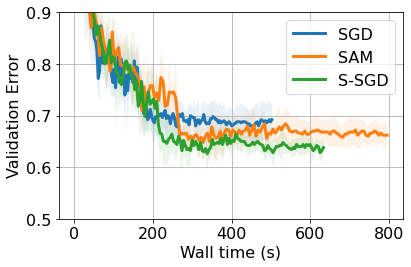

In [40]:
def get_single_iteration_time(opt):
    file = glob.glob(f"../checkpoints/mnist_walltime/lenet/{opt}/run_ms_0/run0/*event*")[0]
    wall_time = []
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag == "Train/Train_Loss":
                wall_time.append(e.wall_time)
    wall_time = [x - wall_time[0] for x in wall_time]
    itr_time = [wall_time[i+1] - wall_time[i] for i in range(len(wall_time)-1)]
    return np.mean(itr_time)

alldata = {}
dtype = 'mnist'
mtype = 'lenet'

for opt in ['sgd', 'sam_sgd', 'fsgd']:
    folders = sorted(glob.glob(f'../checkpoints/{dtype}/{mtype}/{opt}/*'), key=lambda y: y.split('run_ms_')[1])
    alldata[f'{opt}'] = {
        'trainloss': np.zeros((150, len(folders))),
        'trainerr': np.zeros((150, len(folders))),
        'valloss': np.zeros((150, len(folders))),
        'valerr': np.zeros((150, len(folders))),
        'walltime': np.arange((150)) * get_single_iteration_time(f'{opt}')
    }
    data = alldata[f'{opt}']

    for k, f in enumerate(folders):
        file = glob.glob(f'{f}/*event*')[0]
        for e in tf.compat.v1.train.summary_iterator(file):
            for v in e.summary.value:
                if v.tag == "Train/Train_Loss":
                    data['trainloss'][e.step, k] = v.simple_value
                if v.tag == "Val/Val_Loss":
                    data['valloss'][e.step, k] = v.simple_value
                if v.tag == "Train/Train_Err" or v.tag == "Train/Train_Err1":
                    data['trainerr'][e.step, k] = v.simple_value
                if v.tag == "Val/Val_Err" or v.tag == "Val/Val_Err1":
                    data['valerr'][e.step, k] = v.simple_value

    for k,v in data.items():
        if k != 'walltime':
            data[k] = {}
            data[k]['mean'] = v.mean(1)
            data[k]['std'] = v.std(1)

fig, axs = plt.subplots(figsize=(6,4))

for i, opt in enumerate(['sgd', 'sam_sgd', 'fsgd']):
    x = alldata[f"{opt}"]["walltime"][:-1]
    m = alldata[f"{opt}"]["valerr"]['mean'][:-1]
    s = alldata[f"{opt}"]["valerr"]['std'][:-1]
    axs.plot(x, m)
    axs.fill_between(x, m+s, m-s, alpha=0.1)

axs.set_ylim([0.5,0.9])
axs.set_xlabel("Wall time (s)")
axs.set_ylabel("Validation Error")
axs.grid()
plt.legend(["SGD","SAM", "S-SGD"])
plt.tight_layout()
plt.savefig(f"{dtype}_{mtype}_val.png")